In [3]:
using Distributions
using Random
using Plots
using PyPlot
using StatsBase

# Updates

We have introduced Unif-BAS and Cont-BAS for training with the Binary Action Space (BAS). Retroactively, we shall now call the restricted action space the Linear Action Space, or LAS. Alongside this, we have introduced gEval-BAS, which evaluates the VFA using just the BAS actions, whereas gEval would essentially perform PI using the LAS.

We also investigate the use of single indicator functions for the inhomogeneous problem, omitting the expensive and often small cross-terms. Results show that they are not missed.

We also add a new version of AVI-Cont, in which a value g0 is provided for action selection. This was motivated by some inital not-so-good results for an N = 10 inhomogeneous problem. However, fixing g0 = 0 in the AVI, we got a much better policy.

# AVI-Suite

AVI-Suite provides the necessary functions for uniformised AVI, continuous time AVI, evaluation via simulation, and exact evaluation via DP, all in one place. This provides a flexible testbed for testing all four of the AVI algorithms, and ensures that all functions are named such that their purpose is clear, and there is no confusion between similar functions.

Sections:

-[Miscellaneous Functions](#Miscellaneous-Functions)

-[Pre-requisite functions for uniformised AVI](#Pre-requisite-functions-for-uniformised-AVI)

-[Uniformised AVI functions](#Uniformised-AVI-functions)

-[Pre-requisite functions for continuous time AVI](#Pre-requisite-functions-for-continuous-time-AVI)

-[Continuous time AVI Functions](#Continuous-time-AVI-Functions)

-[Pre-requisite Functions for Exact DP on Homogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Homogeneous-Problems)

-[Exact DP on Homogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Homogeneous-problem)

-[Pre-requisite Functions for Exact DP on Inhomogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Inhomogeneous-Problems)

-[Exact DP on Inhomogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Inhomogeneous-Problem-(using-exact-h-or-VFA))

-[Evaluation via simulation](#Evaluation-via-simulation)

-[APE on Fully Active Policy](#APE-on-Fully-Active-Policy)

-[APE using a given VFA](#APE-using-a-given-VFA)

-[New Functions](#New-Functions)

-[Tests](#Tests)

# Miscellaneous Functions

-Functions for enumerating state and action spaces

-Functions for calculating flows given a state or state-action pair

-Function for evaluating a VFA at a given state

In [5]:
#produce an array of array representations of all possible states
function enumerateStates(N::Int64)
    if N==1
        return [[1],[2],[3]]
    end
    
    output = []
    lower = enumerateStates(N-1)
    for s in lower
        new1 = append!([1],s)
        new2 = append!([2],s)
        new3 = append!([3],s)
        append!(output,[new1])
        append!(output,[new2])
        append!(output,[new3])
    end
    
    return output
end

#produce an array of array representations of all possible actions
function enumerateActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = []
    lower = enumerateActions(N-1)
    for a in lower
        new1 = append!([0],a)
        new2 = append!([1],a)
        append!(output,[new1])
        append!(output,[new2])
    end
    
    return output
end    

#produce array of array representations of all restricted, or single-repair, actions
function enumerateRestrictedActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = [zeros(Int64,N)]
    for i in 1:N
        temp = zeros(N)
        temp[i] = 1
        append!(output,[temp])
    end
    
    return output
end

#convert all array elements to string, then concatanate all elements (DEPRECATED AS DICTS CAN TAKE ARRAYS AS KEYS)
function arrayToString(x)
    return join(string.(x))
end

arrayToString (generic function with 1 method)

In [6]:
#function for calculating the flows given a state
function calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    #update flows
    flows = zeros(N)
    healthy = sum(i == 1 for i in s)
    
    #if no links are healthy, return 
    if healthy == 0
        return flows, c1
    end
    
    #otherwise, find best route, and return
    bestCost = maximum(c0) + 1
    usedLink = 0
    for k in 1:N
        if s[k] == 1 && c0[k] < bestCost
            bestCost = c0[k]
            usedLink = k
        end
    end
    
    flows[usedLink] = beta
    
    return flows, bestCost
end

#function for calculating the flows given a state-action pair
function calculateFlows(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    sPrime = s - a
    return calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
end

calculateFlows (generic function with 2 methods)

In [7]:
#evaluate a VFA at a given state
function v(s, params, features)
    numFeatures = length(features)
    return params[1] + sum(params[i+1]*features[i](s) for i in 1:numFeatures)
end

v (generic function with 1 method)

# Pre-requisite functions for uniformised AVI

In [8]:
#Given a state-action pair, return the next random pre-decision state, the instant cost, and the updated flows
function updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #observe exogenous information
    w = rand(Uniform(0, 1))
    
    #interpret exog info: is it a demand deg, rare deg, or completed repair 
    found = false
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        if runningTotal <= w <= runningTotal + flows[k]*alpha_d[k]*del
            found = true
            sPrime[k] = 3
            #println("Demand Deg at "*string.(k))
            break
        end
        runningTotal = runningTotal + flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    if found == false
        for k in 1:N
            if runningTotal <= w <= runningTotal + alpha_r[k]*del
                found = true
                sPrime[k] = 3
                #println("Rare Deg at "*string.(k))
                break
            end
            runningTotal = runningTotal + alpha_r[k]*del
        end
    end
    
    #repairs
    if found == false && repair > 0
        if runningTotal <= w <= runningTotal + tau(repair)*del
            found = true
            #find all repairing links
            repairing = []
            for k in 1:N
                if sPrime[k] == 2
                    append!(repairing,[k])
                end
            end
            repaired = sample(repairing)
            sPrime[repaired] = 1
            #println("Repair completed at "*string.(repaired))
        end
    end
    
    if found == false
        #println("No Event")
    end
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    healthy = sum(i == 1 for i in sPrime)
    
    return sPrime, (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del, newFlows
end

updateStateAndFlowsUnif (generic function with 1 method)

In [9]:
#instant cost over the timestep
function instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    sPrime = s - a
    healthy = sum(sPrime[i] == 1 for i in 1:N)
    repair = sum(sPrime[i] == 2 for i in 1:N)
    damaged = sum(sPrime[i] == 3 for i in 1:N)
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    
    return (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del
end

instantCostUnif (generic function with 1 method)

In [10]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h. Also used in Exact PE/PI when using a VFA
#One version takes flows as an argument, the other calculates the flows
function expectedNextValueUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*v(sPrime, vParams, features)
end  

function expectedNextValueUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, vParams, features)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    flows = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    runningTotal = 0.0
    runningTotalProb = 0.0
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*v(sPrime, vParams, features)
end  

expectedNextValueUnif (generic function with 2 methods)

# Uniformised AVI functions

In [11]:
#Performs AVI in uniformised setting, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state
function approxValueIterationUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - g
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
            
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationUnifApprox (generic function with 1 method)

In [12]:
#Performs AVI in uniformised setting, approximating E(h(s')) using all possible transitions
function approxValueIterationUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - g
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
            
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationUnifFull (generic function with 1 method)

# Pre-requisite functions for continuous time AVI

In [13]:
#Calculate the expected sojourn time of a state-action pair
function sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    s = s - a
    if s == fill(3,N)
        return 1/(beta*sum(alpha_d) + sum(alpha_r) + tau(N))
    end
    
    numRep = sum(i == 2 for i in s)
    cumulativeRate = 0.0
    for i in 1:N
        if s[i] == 1
            cumulativeRate += flows[i]*alpha_d[i] + alpha_r[i]
        elseif s[i] == 2
            cumulativeRate += alpha_r[i] + tau(numRep)/numRep
        end
    end
    
    return 1/cumulativeRate
end

sojournTime (generic function with 1 method)

In [14]:
#calculate the expected cost accumulated until a transition 
function instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = 0)
    if del == 0
        del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    end
    
    return instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
end

instantCostCont (generic function with 1 method)

In [15]:
#Given a state-action pair, return the next random pre-decision state, the cost accumulated over the sojourn time, and the updated flows
function updateStateAndFlowsCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    actualTime = rand(Exponential(del))
    result = updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    return result[1], instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = actualTime), result[3], actualTime
end

updateStateAndFlowsCont (generic function with 1 method)

In [16]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h
function expectedNextValueCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime,vParams,features)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
            end
        end
    end
    
    return runningTotal
end   

expectedNextValueCont (generic function with 1 method)

# Continuous time AVI Functions

In [17]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
function approxValueIterationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures) <= optV
                    optV = vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures)
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationCont (generic function with 1 method)

In [18]:
#Performs AVI in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
function approxValueIterationContST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    actionFlag = false
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update stateTrace
        append!(stateTrace, [s])
        
        #formulate optimal action and calculate optV
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                testV = v(s-a, vParams, features)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
        
        #If wanted, force a repair if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA = zeros(Int64,N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #if optimal action is passive, update VFA for all states in the stateTrace, and simulate the next state
        if bestA == zeros(Int64, N)
            
            #find simulated next state
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
        
            bestV = optV - v(s0, vParams, features)
            
            #update VFA
            traceLength = length(stateTrace)
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            #reset stateTrace
            stateTrace = []
            
            #update flows and average
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #if some action is optimal, simply update the state
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationContST (generic function with 1 method)

In [155]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions, and controlling action selection using some fixed g0
function approxValueIterationContg0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features, g0; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures) <= optV
                    optV = vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures)
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV + g0*t - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationContg0 (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Homogeneous Problems 

In [19]:
#instant cost function strictly for homogeneous problem
function instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    
    #if no links are healthy, return 
    if N - i1 - i2 == 0
        return (beta*c1 + r*i2Prime)*del
    end
    
    
    return (beta*c0 + r*i2Prime)*del
end

instantCostHomog (generic function with 1 method)

In [20]:
#calculates E(h(s')) from s,a strictly for a homogeneous problem
function expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    thisH = h[i1+1,i2+1]
    
    #if all are damaged
    if i1Prime == N
        return thisH
    end
    
    #if none are healthy
    if N - i1 - i2 == 0
        return thisH + tau(i2Prime)*del*(h[i1Prime+1,i2Prime-1+1] - thisH) + i2Prime*del*alpha_r*(h[i1Prime+1+1, i2Prime-1+1] - thisH)
    end
    
    #if none are repairing
    if i2Prime == 0
        return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH)
    end
    
    return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH) + i2Prime*alpha_r*del*(h[i1Prime+1+1,i2Prime-1+1] - thisH) + tau(i2Prime)*del*(h[i1Prime+1,i2Prime-1+1] - thisH)
end

expectedNextValueHomog (generic function with 1 method)

In [21]:
#calculates the exact PI action strictly for a homogeneous problem
function piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        for a in 2:i1
            testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for a in 1:i1
        testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomog (generic function with 1 method)

In [22]:
#calculates the approx PI action based on instantaneous approximation, strictly for a homogeneous problem
function piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = h[i1-optA+1,i2+optA+1]
        for a in 2:i1
            testH = h[i1-a+1,i2+a+1]
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) - g*del
    for a in 1:i1
        testH = h[i1-a+1,i2+a+1]
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomogApprox (generic function with 1 method)

In [23]:
#calculates the exact PI policy strictly for a homogeneous problem
function piPolicyHomog(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomog (generic function with 1 method)

In [24]:
#calculates the approx PI policy based on instantaneous approximation, strictly for a homogeneous problem
function piPolicyHomogApprox(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomogApprox (generic function with 1 method)

In [25]:
function hFromVFAHomog(N, params, features)
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    return hIn
end

hFromVFAHomog (generic function with 1 method)

# Exact DP for Homogeneous problem

In [26]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rpiHomog(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomog(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomog (generic function with 1 method)

In [27]:
#Evaluates the fully active policy, strictly for a homogeneous problem 
function rpeFAHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = i1
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rpeFAHomog (generic function with 1 method)

In [28]:
#Evaluates an approximate PI policy based on a given exact h function and instananeous actions, strictly for a homogeneous problem 
function rpiHomogApprox(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomogApprox(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomogApprox (generic function with 1 method)

In [29]:
#Evaluates a PI policy based on a given VFA, using instananeous approximation, strictly for a homogeneous problem 
function rpiHomogVFAApprox(N::Int64, params, features, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    #run standard function
    return rpiHomogApprox(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = nMax, delScale = delScale, forceActive = forceActive)
end

rpiHomogVFAApprox (generic function with 1 method)

In [30]:
#Evaluates a PI policy based on a given VFA, strictly for a homogeneous problem 
function rpiHomogVFA(N::Int64, params, features, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    #run standard function
    return rpiHomog(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, forceActive = forceActive)
end

rpiHomogVFA (generic function with 1 method)

In [31]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rviHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rviHomog (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Inhomogeneous Problems

In [32]:
#calculates E(h(s')) from s,a using exact h table
function expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    
    flows = zeros(Float64, N)
    if healthy > 0
        #otherwise, find best route, and return
        bestCost = maximum(c0) + 1
        usedLink = 0
        for k in 1:N
            if sPrime[k] == 1 && c0[k] < bestCost
                bestCost = c0[k]
                usedLink = k
            end 
        end
        
        flows[usedLink] = beta
    end
    
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*h[sNext]
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*h[sPrime]
end 

expectedNextValueExact (generic function with 1 method)

In [33]:
#calculates PI action using exact h table
function piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExact (generic function with 1 method)

In [34]:
#calculates PI action using exact h table, based off instananeous actions
function piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExactInstant (generic function with 1 method)

In [35]:
#calculates PI action using a VFA
function piActionVFA(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionVFA (generic function with 1 method)

In [36]:
#calculates PI action using a VFA and instananeous actions
function piActionVFAInstant(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = v(s-a,params,features)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionVFAInstant (generic function with 1 method)

In [37]:
#calculates PI policy using exact h table
function piPolicyExact(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyExact (generic function with 1 method)

In [38]:
#calculates PI policy using exact h table, interpretting h with instant actions
function piPolicyExactInstant(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyExactInstant (generic function with 1 method)

In [39]:
#calculates PI policy from a VFA
function piPolicyVFA(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionVFA(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyVFA (generic function with 1 method)

In [40]:
#calculates PI policy from a VFA, using instant actions to interpret h
function piPolicyVFAInstant(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionVFAInstant(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyVFAInstant (generic function with 1 method)

# Exact DP for Inhomogeneous Problem (using exact h or VFA)

In [41]:
#Performs PE using exact policy table
function rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpe (generic function with 1 method)

In [42]:
#Performs one round of exact PI and PE using exact h table
function rpiExact(N, h, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = piPolicyExact(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rpiExact (generic function with 1 method)

In [43]:
#Performs one round of exact PI and PE using exact h table, using instant actions to interpet h
function rpiExactInstant(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = piPolicyExactInstant(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiExactInstant (generic function with 1 method)

In [44]:
#Performs exact PE on the fully-active policy
function rpeFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct fully active action
            a = zeros(Int64, N)
            for i in 1:N
                if s[i] == 3
                    a[i] = 1
                end
            end 
            
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpeFA (generic function with 1 method)

In [45]:
#Performs exact PE on the passive policy
function rpePassive(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct fully active action
            a = zeros(Int64, N) 
            
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpePassive (generic function with 1 method)

In [46]:
#Performs one round of exact PI and PE using VFA
function rpiVFA(N, params, features, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    policy = piPolicyVFA(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct action
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiVFA (generic function with 1 method)

In [47]:
#Performs one round of exact PI and PE using VFA and instantaneous actions to interpret h
function rpiVFAInstant(N, params, features, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    policy = piPolicyVFAInstant(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct action
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiVFAInstant (generic function with 1 method)

In [48]:
#Performs RVIA
function rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
        policy[s] = zeros(Int64,N)
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rvi (generic function with 1 method)

# Evaluation via simulation

In [49]:
#Evaluates a VFA via PI using simulation
function gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationCont (generic function with 1 method)

In [50]:
#Evaluates a VFA using simulation
function gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flowResult = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    flows = flowResult[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end 
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationContFromS (generic function with 1 method)

In [51]:
#Evaluates a VFA using simulation
function gEvaluationContFixed(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationContFixed (generic function with 1 method)

In [52]:
#Evaluates a VFA using simulation
function gEvaluationContFromSFixed(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flowResult = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    flows = flowResult[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end 
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationContFromSFixed (generic function with 1 method)

In [53]:
#Evaluates a VFA using simulation
function gEvaluationContFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        bestA = faAction(s)
        
        #update state and flows
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationContFA (generic function with 1 method)

# APE on Fully Active Policy

Performs APE on the Fully Active Policy using each of the four approaches to estimating a VFA (mixes of uniform/continuous and simulated-next-state/expectation)

In [54]:
#Computes the Fully Active action for a given state s
function faAction(s)
    N = length(s)
    a = zeros(Int64,N)
    for i in 1:N
        if s[i] == 3
            a[i] = 1
        end
    end
    return a
end

faAction (generic function with 1 method)

In [55]:
#Performs APE of FA policy in uniformised setting, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state
function apeFAUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAUnifApprox (generic function with 1 method)

In [56]:
#Performs APE of FA policy in uniformised setting, approximating E(h(s')) using all possible transitions
function apeFAUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + expectedNextValueUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAUnifFull (generic function with 1 method)

In [57]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
function apeFAContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + v(sPrime, vParams, features) - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContApprox (generic function with 1 method)

In [58]:
function apeFAContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + expectedNextValueCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContFull (generic function with 1 method)

In [59]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
#Also incorporates the state trace when actions are taken
function apeFAContApproxST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update state trace
        append!(stateTrace, [s])
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #for passive action, do proper update
        if bestA == zeros(Int64,N)
            #find value of v^n
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + v(sPrime, vParams, features) - g*t - v(s0, vParams,features)

            #update VFA
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            stateTrace = []
            
            #update g, state, and flows
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]

            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #for other action, simply update state and move on
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContApproxST (generic function with 1 method)

In [60]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) using all possible transitions
#Also incorporates the state trace when actions are taken
function apeFAContFullST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update state trace
        append!(stateTrace, [s])
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #for passive action, do proper update
        if bestA == zeros(Int64,N)
            #find value of v^n
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + expectedNextValueCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t - v(s0, vParams,features)

            #update VFA
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            stateTrace = []
            
            #update g, state, and flows
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]

            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #for other action, simply update state and move on
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContFullST (generic function with 1 method)

# APE using a given VFA

Performs APE using a given fixed VFA, using each of the four approaches to estimating a VFA (mixes of uniform/continuous and simulated-next-state/expectation)

# New Functions

In [97]:
#Performs AVI with BAS in uniformised setting, approximating E(h(s')) using all possible transitions
function aviUnifBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        vs0 = v(s0, vParams, features)
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - vs0
        
        testA = faAction(s)
        testV = instantCostUnif(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - vs0
        if testV <= optV
            optV = testV
            optA = testA
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA = testA
            optV = testV
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

aviUnifBAS (generic function with 1 method)

In [108]:
#Performs AVI with BAS in the continuous time setting, approximating E(h(s')) using all possible transitions
function aviContBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        tPassive = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tPassive
        
        testA = faAction(s)
        tActive = sojournTime(s, testA, flows, N, alpha_d, alpha_r, beta, tau)
        testV = instantCostCont(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tActive
        
        if testV <= optV
            optV = testV
            optA = testA
        end
        
        #Ignore passive action for broken network
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optV = testV
            optA = testA
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - v(s0, vParams,features)
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

aviContBAS (generic function with 1 method)

In [123]:
#Evaluates a VFA via PI using simulation
function gEvaluationContBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        tPassive = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tPassive
        
        testA = faAction(s)
        tActive = sojournTime(s, testA, flows, N, alpha_d, alpha_r, beta, tau)
        testV = instantCostCont(s,testA, N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tActive
        if testV <= optV
            optV = testV
            optA = testA
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA = testA
            optV = testV
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationContBAS (generic function with 1 method)

# Tests

## Try Unif-BAS on N = 20 problem

In [101]:
Random.seed!(12345)
function tau(n)
    return n
end

#define features
function numRep(s)
    n = length(s)
    return sum(s[i] == 2 for i in 1:n)/n
end

function numDamage(s)
    n = length(s)
    return sum(s[i] == 3 for i in 1:n)/n
end

function numRepSq(s)
    return numRep(s)^2
end

function numDamageSq(s)
    return numDamage(s)^2
end

N=20
alpha_d = [0.01 for i in 1:N]
alpha_r = [0.001 for i in 1:N] 
beta=10.0
c0=[1.0 for i in 1:N] 
c1=100.0
r=[100.0 for i in 1:N]
nMax = 1000000
stepsize = 1/10
features = [numRep, numDamage, numRepSq, numDamageSq]
vParams = zeros(length(features) + 1)
resultUnifBAS = aviUnifBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000, forceActive = true)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


Table Complete


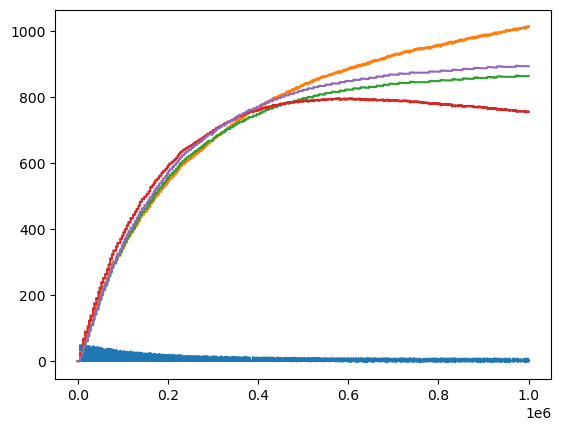

In [102]:
numPar = length(vParams)
paramHist = resultUnifBAS[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [106]:
nMax = 1000000
stepsize = 1/10
resultUnifBAS2 = aviUnifBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, resultUnifBAS[1], features; printProgress = true, modCounter = 100000, forceActive = true)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


Table Complete


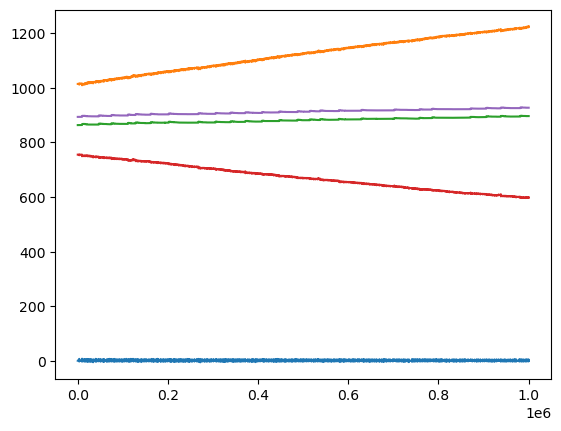

In [107]:
numPar = length(vParams)
paramHist = resultUnifBAS2[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

This bitch don't converge quickly!

## Cont-BAS on N = 20

In [115]:
nMax = 200000
stepsize = 1/10
resultContBAS = aviContBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 10000, forceActive = true)
println("Complete")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
Complete


Table Complete


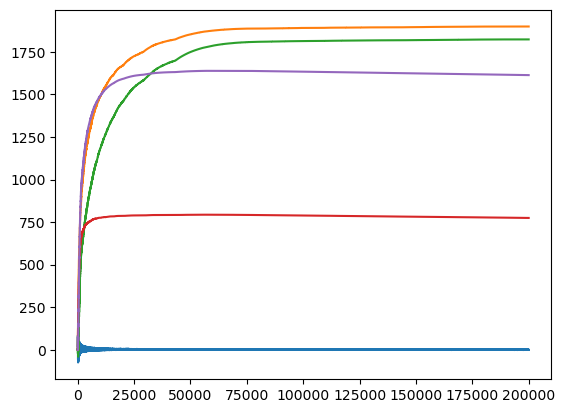

In [116]:
numPar = length(vParams)
paramHist = resultContBAS[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [118]:
resultContBAS[3]

21.83458347929288

In [119]:
h = hFromVFAHomog(N, resultContBAS[1], features)

21×21 Matrix{Float64}:
   -0.0208719    96.8566   197.607  …  2173.58  2336.29  2502.88  2673.34
   95.1634      192.041    292.791     2268.76  2431.48  2598.06     0.0
  198.414       295.292    396.042     2372.01  2534.73     0.0      0.0
  309.732       406.609    507.359     2483.33     0.0      0.0      0.0
  429.116       525.994    626.744        0.0      0.0      0.0      0.0
  556.567       653.445    754.195  …     0.0      0.0      0.0      0.0
  692.085       788.962    889.712        0.0      0.0      0.0      0.0
  835.669       932.547   1033.3          0.0      0.0      0.0      0.0
  987.32       1084.2     1184.95         0.0      0.0      0.0      0.0
 1147.04       1243.92    1344.67         0.0      0.0      0.0      0.0
 1314.82       1411.7     1512.45   …     0.0      0.0      0.0      0.0
 1490.67       1587.55    1688.3          0.0      0.0      0.0      0.0
 1674.59       1771.47    1872.22         0.0      0.0      0.0      0.0
 1866.58       1963.45    2

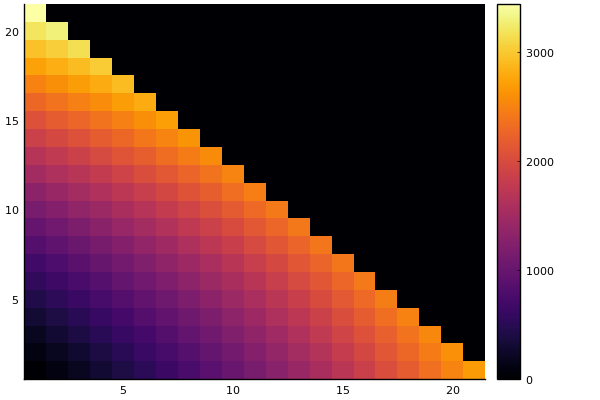

In [120]:
heatmap(h)

In [121]:
evalNMax = 1000000
gs = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContBAS[1], features; printProgress = true, modCounter = 100000)
gs[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
  0.0
 10.0
 10.0
 59.670251350997276
 41.19053514144576
 36.16666138076066
 24.027652583502597
 24.027652583502597
 24.027652583502597
 58.58954930439617
 58.72578750649503
 42.94747254958982
 39.7529914448622
  ⋮
 21.960260935828682
 21.96027466397097
 21.96026817476061
 21.96026817476061
 21.9602876382847
 21.960252866732024
 21.960252866732024
 21.960260506713833
 21.960260083505354
 21.960260083505354
 21.96032145639272
 21.960315262291555

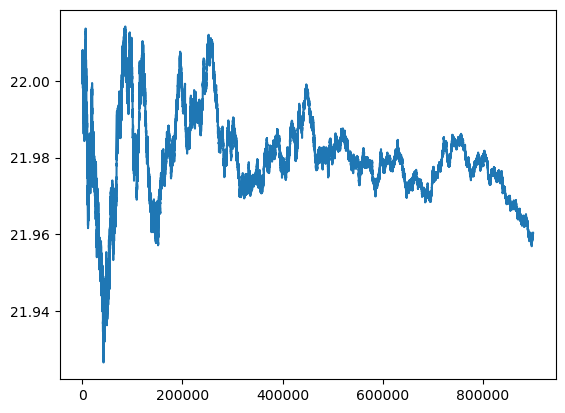

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000B0AB58B0>

In [122]:
PyPlot.plot(gs[1][100000:evalNMax])

In [124]:
gsBAS = gEvaluationContBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContBAS[1], features; printProgress = true, modCounter = 100000)
gsBAS[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
  0.0
  9.999999999999998
  9.999999999999998
 17.16927462659239
 13.653677367431028
 13.653677367431028
 13.910141882073981
 13.226056813501005
 13.226056813501005
 14.368093259794584
 14.368093259794584
 17.73423028981323
 24.313040843385703
  ⋮
 21.880009688697083
 21.880022577489797
 21.87994238493212
 21.87985709752393
 21.87985709752393
 21.879888163828106
 21.87991469235183
 21.879906640392512
 21.879870676819873
 21.879870676819873
 21.879894898610495
 21.87990900913314

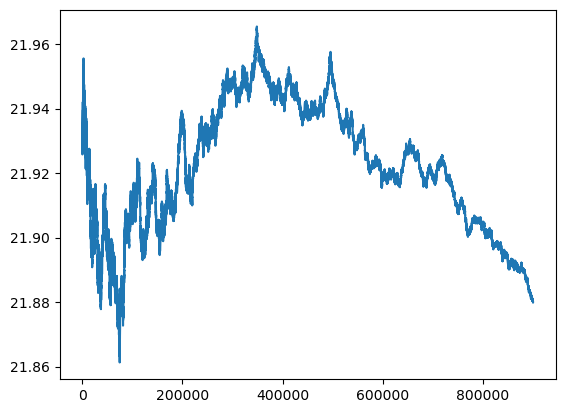

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006EC1E460>

In [125]:
PyPlot.plot(gsBAS[1][100000:evalNMax])

It appears that the BAS policy derived from the VFA is slightly better than a general policy derived from the same VFA. This is understandable, as the VFA has poor information for cases where some links are left damaged. We can also run the FA policy for additional comparison.

Specifically, the policy derived from PI using the BAS has a long-run average between 21.86 and 21.96, whereas the policy derived from PI using the LAS has a long-run average between 21.93 and 22.01. We now run the FA policy for additional comparison.

In [126]:
gsFA = gEvaluationContFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax; printProgress = true, modCounter = 100000)
gsFA[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
  0.0
 10.0
 10.0
 43.375250515434715
 16.3834496327592
 16.3834496327592
 21.704721164713337
 19.44513649188117
 19.44513649188117
 22.85871710884184
 18.663383910311786
 18.663383910311786
 19.878473233496614
  ⋮
 21.97306753571883
 21.97307258729922
 21.973032446271944
 21.973032446271944
 21.973107132651304
 21.97310162874116
 21.97310162874116
 21.973124902498416
 21.973124704506223
 21.973124704506223
 21.97318309266643
 21.97314506427566

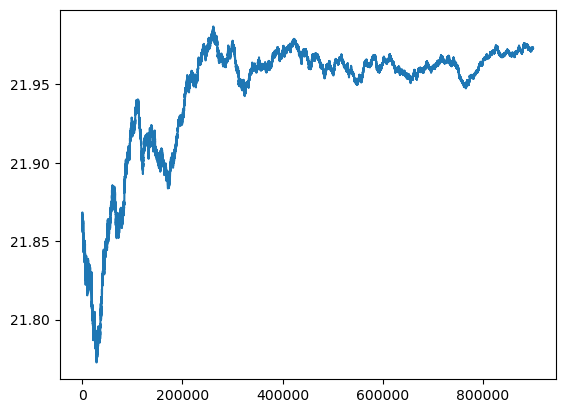

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006EDEAD90>

In [127]:
PyPlot.plot(gsFA[1][100000:evalNMax])

FA policy has long-run average between 21.75 and 22.00, stabilising around 21.95. Seems to be very little difference between BAS and FA.

## Cont-BAS on N = 5 inhomogeneous

In [128]:
N=5
alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:5] 
c1=100.0
r=[100.0*i for i in 1:5] 
repIndicators = [s -> (s[i]==2)*(s[j]==2) for i in 1:N for j in i:N]
damIndicators = [s -> (s[i]==3)*(s[j]==3) for i in 1:N for j in i:N]
indicators = [repIndicators;damIndicators]
features = indicators
vParams = zeros(length(features) + 1)
nMax = 100000
stepsize = 1/10
resultContBAS = aviContBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 10000)
println("Complete")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
Complete


Table Complete


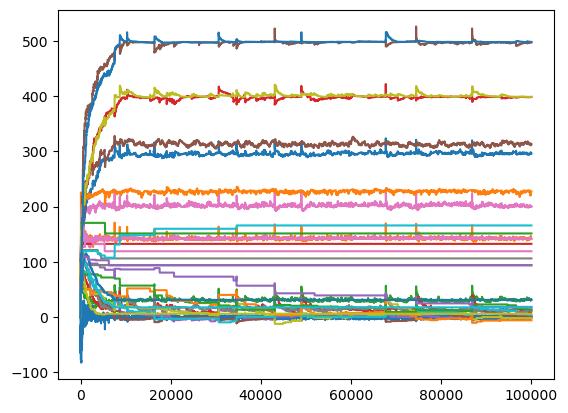

In [129]:
numPar = length(vParams)
paramHist = resultContBAS[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [130]:
evalNMax = 1000000
gs = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContBAS[1], features; printProgress = true, modCounter = 100000)
gs[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
  0.0
 10.0
 10.0
 15.998033460810747
 10.625217956335439
 10.625217956335439
 34.346915903154205
 31.633427253262155
 31.633427253262155
 33.335063317329876
 26.974225954293495
 26.974225954293495
 27.792238078130854
  ⋮
 29.7648289599196
 29.7648289599196
 29.764919451860465
 29.764913055801195
 29.764913055801195
 29.764948095858863
 29.764948095858863
 29.765011958565154
 29.765097081679734
 29.76500374304085
 29.76500374304085
 29.765032104043964

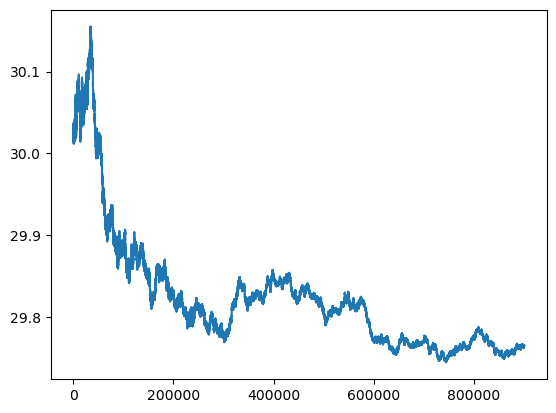

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007F74E760>

In [131]:
PyPlot.plot(gs[1][100000:evalNMax])

In [132]:
gsBAS = gEvaluationContBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContBAS[1], features; printProgress = true, modCounter = 100000)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


([0.0, 10.0, 10.0, 18.48529645118117, 14.834410882299178, 14.834410882299178, 17.353017583382293, 15.218765397841416, 15.218765397841416, 16.155626892688833  …  29.773525380560756, 29.773525380560756, 29.773550076887155, 29.773550076887155, 29.773783482578125, 29.773815400359673, 29.773637774350668, 29.773637774350668, 29.773665097231376, 29.773600153916014], [0.0, 175.22072094942342, 350.9745429675953, 494.359588784632, 592.4819684876921, 732.1117605945084, 784.1918388313718, 808.4877439234796, 872.7068735191588, 881.1781537059082  …  7.9192418111012e7, 7.919243009801711e7, 7.919263631837156e7, 7.919266601305982e7, 7.919275337744708e7, 7.919343576577404e7, 7.91935486768408e7, 7.919378760937895e7, 7.91938842664498e7, 7.919397162553011e7], [0.0, 17.52207209494234, 18.98668727842711, 33.32519186013078, 34.14287835765628, 48.105857568337896, 48.53985822031176, 50.96944872952254, 51.27525410854958, 52.12238212722453  …  2.65982915136338e6, 2.6598303500638916e6, 2.6598320685668453e6, 2.6598

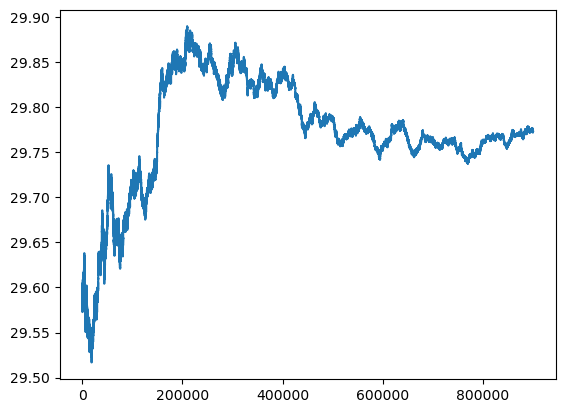

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000009A99580>

In [133]:
PyPlot.plot(gsBAS[1][100000:evalNMax])

In [134]:
gsFA = gEvaluationContFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax; printProgress = true, modCounter = 100000)
gsFA[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
   0.0
  10.0
  10.0
 120.26158187968474
  69.1629912544932
  69.1629912544932
  92.30262170631994
  39.347806836297494
  39.347806836297494
  50.17303611394576
  35.771687509380186
  35.771687509380186
  40.579883092738896
   ⋮
  29.786751513051026
  29.786756485759334
  29.786756485759334
  29.786758219592233
  29.78686434555143
  29.786793393081535
  29.786793393081535
  29.786840026027882
  29.786840026027882
  29.786882570332477
  29.78690238847609
  29.786871291135302

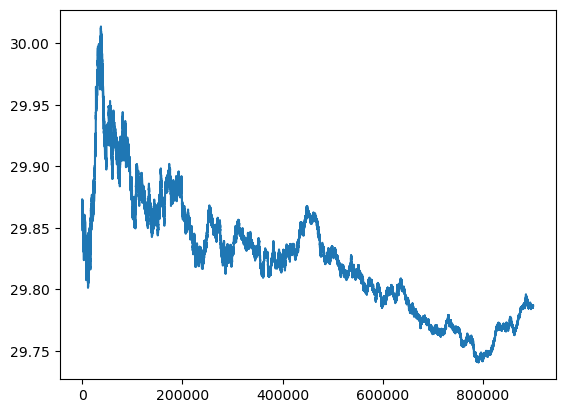

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007F6755B0>

In [135]:
PyPlot.plot(gsFA[1][100000:evalNMax])

# Inhomogeneous without cross-terms

In [142]:
N=5
alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:5] 
c1=100.0
r=[100.0*i for i in 1:5] 
repIndicators = [s -> (s[i]==2) for i in 1:N]
damIndicators = [s -> (s[i]==3) for i in 1:N]
indicators = [repIndicators;damIndicators]
features = indicators
vParams = zeros(length(features) + 1)
nMax = 1000000
stepsize = 1/100
resultCont = approxValueIterationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


In [143]:
resultCont[3]

27.273483480445154

Table Complete


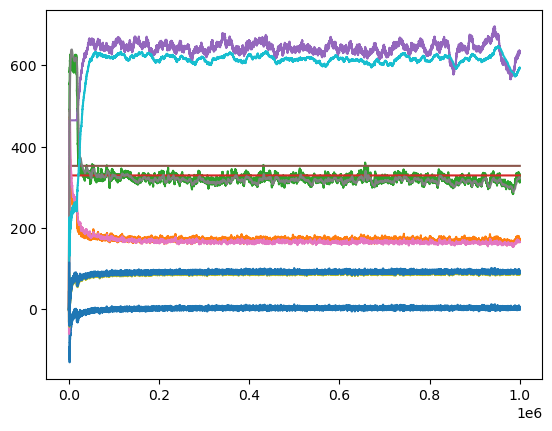

In [144]:
numPar = length(vParams)
paramHist = resultCont[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [145]:
evalNMax = 1000000
gs = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultCont[1], features; printProgress = true, modCounter = 100000)
gs[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
  0.0
 10.0
 10.0
 42.677040556200446
 31.219369475169792
 31.219369475169792
 32.70506988547225
 23.727192601199125
 23.727192601199125
 24.494236505403123
 23.411131228006944
 23.411131228006944
 23.608566413520904
  ⋮
 27.228812036752682
 27.228789451918356
 27.228789451918356
 27.228843249094968
 27.228830759589684
 27.228830759589684
 27.22886684612666
 27.22886684612666
 27.228896080267866
 27.229025291502463
 27.22893420515286
 27.22893420515286

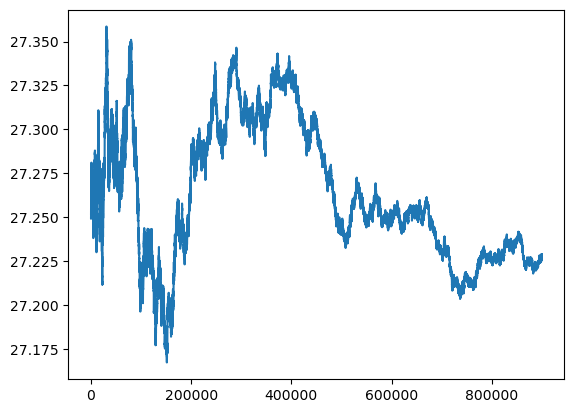

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000009B7D070>

In [146]:
PyPlot.plot(gs[1][100000:evalNMax])

In [148]:
N=10
alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:N] 
c1=100.0
r=[100.0*i for i in 1:N] 
repIndicators = [s -> (s[i]==2) for i in 1:N]
damIndicators = [s -> (s[i]==3) for i in 1:N]
indicators = [repIndicators;damIndicators]
features = indicators
vParams = zeros(length(features) + 1)
nMax = 1000000
stepsize = 1/100
resultCont = approxValueIterationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


In [149]:
resultCont[3]

42.65626827133801

Oh no

Table Complete


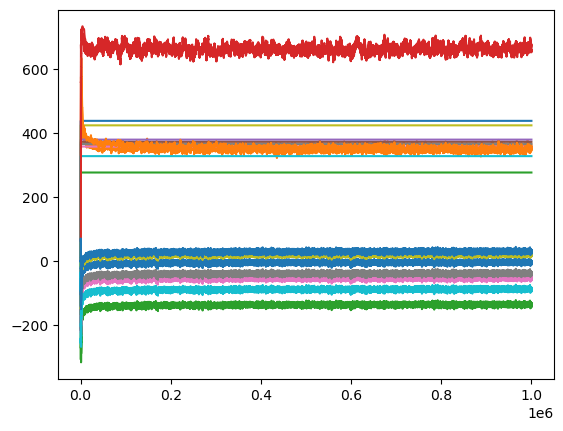

In [150]:
numPar = length(vParams)
paramHist = resultCont[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [151]:
evalNMax = 1000000
gs = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultCont[1], features; printProgress = true, modCounter = 100000)
gs[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
  0.0
 10.0
 18.244852309903102
 18.244852309903102
 20.111896080368307
 18.743784700745504
 14.27933726141676
 14.27933726141676
 18.0597905605808
 15.031151109138438
 15.031151109138438
 16.76647031291266
 14.874883478266863
  ⋮
 42.612632715434486
 42.61269050258158
 42.61269050258158
 42.613066881163874
 42.61313429009452
 42.61312895776371
 42.61312895776371
 42.61313142281567
 42.61309898853298
 42.61309898853298
 42.613147523139574
 42.61301100861759

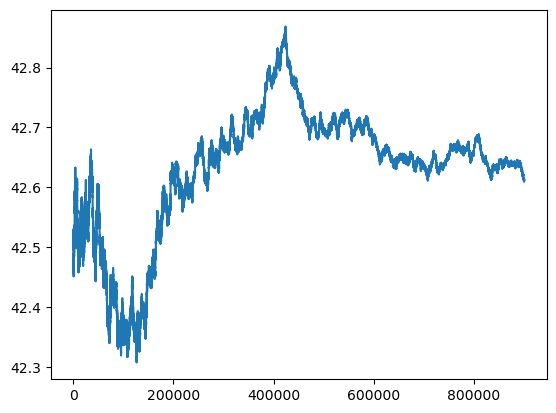

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000009CB8490>

In [152]:
PyPlot.plot(gs[1][100000:evalNMax])

In [153]:
g0 = 0.0
gsFixed = gEvaluationContFixed(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultCont[1], features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
gsFixed[1]

1000001-element Vector{Float64}:
  0.0
 10.0
 19.366442116577705
 19.401501039547554
 19.401501039547554
 19.58728531888249
 18.33275089837151
 18.33275089837151
 19.281118379489605
 17.18246071574092
 16.852871058840837
 16.852871058840837
 19.96797868359388
  ⋮
 44.96131436475154
 44.961398122633746
 44.961383303798236
 44.961383303798236
 44.961448946203255
 44.96141831727349
 44.96141831727349
 44.96144934807776
 44.96140664221965
 44.96140664221965
 44.961436094545164
 44.96134698340826

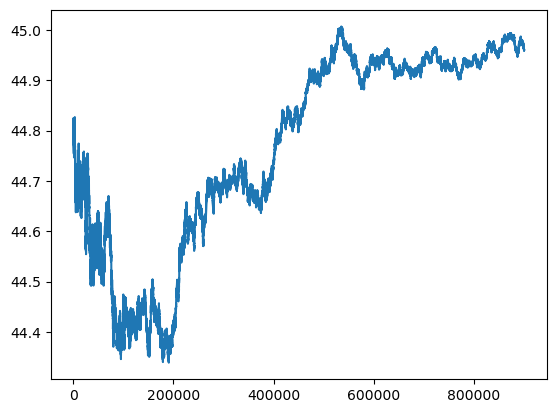

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000009CD1E50>

In [154]:
PyPlot.plot(gsFixed[1][100000:evalNMax])

## SMARVI-g0

In [156]:
N=10
alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:N] 
c1=100.0
r=[100.0*i for i in 1:N] 
repIndicators = [s -> (s[i]==2) for i in 1:N]
damIndicators = [s -> (s[i]==3) for i in 1:N]
indicators = [repIndicators;damIndicators]
features = indicators
vParams = zeros(length(features) + 1)
g0 = 0.0
nMax = 1000000
stepsize = 1/100
resultCont = approxValueIterationContg0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features, g0; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


Table Complete


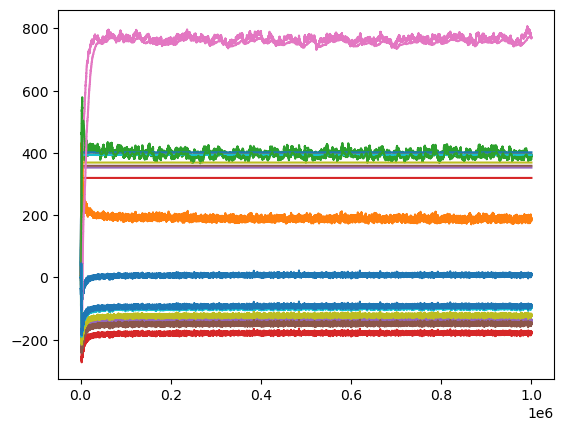

In [157]:
numPar = length(vParams)
paramHist = resultCont[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [158]:
resultCont[3]

29.890111365633018

In [159]:
evalNMax = 1000000
gs = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultCont[1], features; printProgress = true, modCounter = 100000)
gs[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
  0.0
 10.0
 10.0
 15.80811849643966
 14.633592280393849
 11.364776553263798
 11.364776553263798
 12.10768803542793
 11.180535303900875
 11.062272344148067
 10.692616118637726
 10.674706527769601
 10.674706527769601
  ⋮
 29.67577261396612
 29.675701299163403
 29.675701299163403
 29.675825746416926
 29.675813717661423
 29.675813717661423
 29.675827211443213
 29.675810511915284
 29.675810511915284
 29.67582155999392
 29.67579011685321
 29.67579011685321

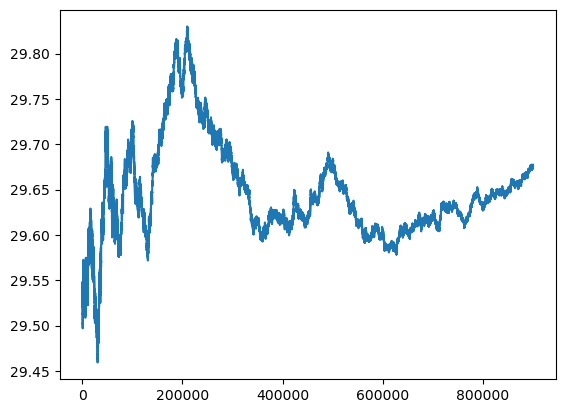

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000009E4B280>

In [160]:
PyPlot.plot(gs[1][100000:evalNMax])

In [164]:
gsFA = gEvaluationContFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax; printProgress = true, modCounter = 100000)
gsFA[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
  0.0
 10.0
 10.0
 18.36073932023473
 18.36073932023473
 22.714914842872787
 22.714914842872787
 28.23487003128195
 38.23862069096697
 38.23862069096697
 56.99131450141389
 57.11503733694883
 69.16500799600185
  ⋮
 62.41165173475584
 62.41165173475584
 62.411715275838844
 62.41132641492698
 62.41132641492698
 62.41133624067976
 62.41133624067976
 62.4114700853725
 62.41148589998405
 62.41148589998405
 62.41172128140227
 62.411744333110605

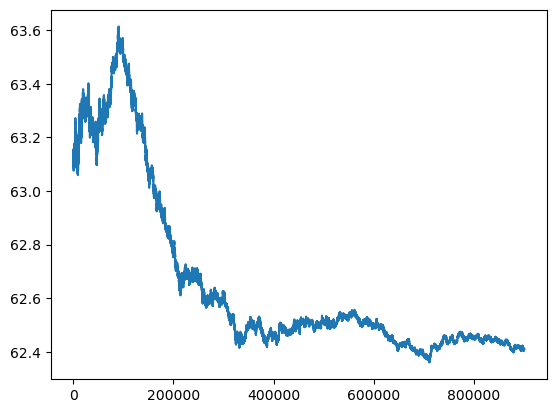

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000009D83A30>

In [165]:
PyPlot.plot(gsFA[1][100000:evalNMax])